# TREINAMENTO REDE EFFICIENTNET v3.2EF.30e.2Cle

**Rede:** Efficient Net

> Com os pesos congelados

**Dataset:** Cleaned Localized Equilibrado

> Epochs = 30

> Batch = 512

> Target = (100, 100)

> SEED = 10

> CLUSTERIZAÇÃO? Não

**Obs.:** Com separação de indivíduo

In [1]:
!nvidia-smi

Tue Oct  1 05:02:03 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
os.environ['TF_DISABLE_JIT'] = '1'

In [3]:
!jupyter notebook --NotebookApp.iopub_msg_rate_limit=1.0e10

[I 05:02:08.494 NotebookApp] [nb_conda_kernels] enabled, 1 kernels found
[I 05:02:08.623 NotebookApp] Writing notebook server cookie secret to /root/.local/share/jupyter/runtime/notebook_cookie_secret

  _   _          _      _
 | | | |_ __  __| |__ _| |_ ___
 | |_| | '_ \/ _` / _` |  _/ -_)
  \___/| .__/\__,_\__,_|\__\___|
       |_|
                       
Read the migration plan to Notebook 7 to learn about the new features and the actions to take if you are using extensions.

https://jupyter-notebook.readthedocs.io/en/latest/migrate_to_notebook7.html

Please note that updating to Notebook 7 might break some of your extensions.

[I 05:02:09.063 NotebookApp] Registered dataproc_jupyter_plugin server extension
jupyter_http_over_ws extension initialized. Listening on /http_over_websocket
[I 05:02:09.611 NotebookApp] Skipped non-installed server(s): bash-language-server, dockerfile-language-server-nodejs, javascript-typescript-langserver, jedi-language-server, julia-language-server, pyr

## Bibliotecas e Constantes

In [4]:
#!pip install tensorflow[and-cuda]

In [5]:
!pip install efficientnet

!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 723.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 717.6 kB/s eta 0:00:00


In [6]:
#------------------------------------------------------------------------------
# BIBLIOTECAS

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys
import random

# BIBLIOTECAS DEEP LEARNING
import datetime
import tensorflow as tf
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing import image

from efficientnet.tfkeras import EfficientNetB7

#------------------------------------------------------------------------------
# CONSTANTES

DATASET_TYPE = ['cleaned', 'selected', 'selected-localized', 'cleaned-localized']
DATASET_TYPE = DATASET_TYPE[3] # Dataset utilizado no treinamento

DATASET_COMPLETO = False

CNN_MODEL = 'efficient-net' # Rede utilizada no treinamento

SEED = 10
np.random.seed(SEED) # semente geradora dos numeros aleatorios
random.seed(SEED)
tf.random.set_seed(SEED)

N_FOLDS = 5
N_EPOCHS = 30
BATCH_SIZE = 32
SIZE = 100
TARGET_SIZE = (SIZE, SIZE)

VERSION = '2.1EF.30e.2CLe'

2024-10-01 05:02:48.748712: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-01 05:02:48.748833: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 05:02:49.015583: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Diretórios e Carregamentos de Dados

In [7]:
# Criando pasta de resultados
if not os.path.exists(f'{DATASET_TYPE}'):
    os.mkdir(f'{DATASET_TYPE}')

In [8]:
#------------------------------------------------------------------------------
# DIRETÓRIOS DOS DATASETS

DATASET_PATH = f'/kaggle/input/myocardit-dataset-cleaned-localized'
RESULTS_PATH = f'/kaggle/working/{DATASET_TYPE}'

NORMAL_PATH = DATASET_PATH + '/Normal/'
SICK_PATH = DATASET_PATH + '/Sick/'

# Diretorios de cada Individuo:
normal_datasets = [f'{NORMAL_PATH}Individuo_{i:02}/' for i in range(1, 17)]
sick_datasets = [f'{SICK_PATH}Individuo_{i:02}/' for i in range(1, 32)]

print(normal_datasets)
print(sick_datasets)

NORMAL_SPLITS = [[2, 10, 14],
                 [4, 7, 13],
                 [6, 8, 11, 15, 16],
                 [1, 5],
                 [3, 3, 12]]

#Grupo 1: ['Individuo_2', 'Individuo_10', 'Individuo_14'], Soma: 1334.0
#Grupo 2: ['Individuo_4', 'Individuo_7', 'Individuo_13'], Soma: 1342.0
#Grupo 3: ['Individuo_6', 'Individuo_8', 'Individuo_11', 'Individuo_15', 'Individuo_16'], Soma: 1339.0
#Grupo 4: ['Individuo_1', 'Individuo_5'], Soma: 1321.0
#Grupo 5: ['Individuo_3', 'Individuo_9', 'Individuo_12'], Soma: 1339.0
#Soma total: 6675.0, Média por grupo: 1335.0

if DATASET_COMPLETO == True:
    SICK_SPLITS = [[18, 29, 32, 35, 41, 43, 45],
                   [19, 20, 27, 34, 42],
                   [17, 23, 30, 33, 38],
                   [22, 28, 31, 36, 37, 40, 44, 47],
                   [21, 24, 25, 25, 39, 46]]
    
#Grupo 1: ['Individuo_18', 'Individuo_29', 'Individuo_32', 'Individuo_35', 'Individuo_41', 'Individuo_43', 'Individuo_45'], Soma: 2637.0
#Grupo 2: ['Individuo_19', 'Individuo_20', 'Individuo_27', 'Individuo_34', 'Individuo_42'], Soma: 2636.0
#Grupo 3: ['Individuo_17', 'Individuo_23', 'Individuo_30', 'Individuo_33', 'Individuo_38'], Soma: 2637.0
#Grupo 4: ['Individuo_22', 'Individuo_28', 'Individuo_31', 'Individuo_36', 'Individuo_37', 'Individuo_40', 'Individuo_44', 'Individuo_47'], Soma: 2637.0
#Grupo 5: ['Individuo_21', 'Individuo_24', 'Individuo_25', 'Individuo_26', 'Individuo_39', 'Individuo_46'], Soma: 2636.0
#Soma total: 13183.0, Média por grupo: 2636.6
    
else:
    SICK_SPLITS = [[24, 33, 35, 41],
                   [25, 32, 36, 42],
                   [26, 31, 37, 43],
                   [27, 30, 39, 45],
                   [28, 29, 38, 44]]
    
#Grupo 1: ['Individuo_24', 'Individuo_33', 'Individuo_35', 'Individuo_41'], Soma: 1348.0
#Grupo 2: ['Individuo_25', 'Individuo_32', 'Individuo_36', 'Individuo_42'], Soma: 1369.0
#Grupo 3: ['Individuo_26', 'Individuo_31', 'Individuo_37', 'Individuo_43'], Soma: 1401.0
#Grupo 4: ['Individuo_27', 'Individuo_30', 'Individuo_39', 'Individuo_45'], Soma: 1430.0
#Grupo 5: ['Individuo_28', 'Individuo_29', 'Individuo_38', 'Individuo_44'], Soma: 1429.0
#Média das somas dos grupos: 1395.40


normal_splits = [[],[],[],[],[]]
sick_splits = [[],[],[],[],[]]

for split in range(N_FOLDS):
    normal_splits[split].extend(normal_datasets[i-1] for i in NORMAL_SPLITS[split])
    sick_splits[split].extend(sick_datasets[i-17] for i in SICK_SPLITS[split])

['/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_01/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_02/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_03/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_04/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_05/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_06/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_07/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_08/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_09/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_10/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_11/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_12/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_13/', '/kaggle/input/myocardit-dataset-clea

In [9]:
#------------------------------------------------------------------------------
# CARREGAMENTO DE DADOS COM SEPARAÇÃO DE INDIVIDUOS

print('\nIniciando carregamento e processamento das imagens..............!')

def carregar_imagens(diretorio):
    global num_imagens
    imagens = []
    for pasta_atual, subpastas, arquivos in os.walk(diretorio):
        for arquivo in arquivos:
            if arquivo.endswith(('.jpg', '.jpeg', '.png')):
                caminho = os.path.join(pasta_atual, arquivo)
                
                img = Image.open(caminho)
                img = img.resize(TARGET_SIZE)
                img = img.convert('L')
                img_array = np.array(img)
                imagens.append(img_array)
                
                num_imagens += 1
                sys.stdout.write("\rNumero de imagens carregados: %i" % num_imagens)
                sys.stdout.flush()
                
    return imagens

num_imagens = 0

print('\nPacientes normais:')
normal_groups = []
for diretorios in normal_splits:
    imagens = []
    for individuos in diretorios:
        imagens.extend(carregar_imagens(individuos))
    normal_groups.append(imagens)

num_imagens = 0

print('\n\nPacientes doentes:')
sick_groups = []
for diretorios in sick_splits:
    imagens = []
    for individuos in diretorios:
        imagens.extend(carregar_imagens(individuos))
    sick_groups.append(imagens)

# DATASETS SEPRADAOS EM 5 PARA VALIDAÇÃO CRUZADA    
x_data = [[],[],[],[],[]]
y_data = [[],[],[],[],[]]

print('\n\nNumero de imagens por split:')
for i in range(N_FOLDS):
    x_data[i].extend(path for path in normal_groups[i])
    y_data[i].extend([1, 0] for path in normal_groups[i])
    x_data[i].extend(path for path in sick_groups[i])
    y_data[i].extend([0, 1] for path in sick_groups[i])
    print(f'Split {i+1}: {len(x_data[i])} imagens ({len(normal_groups[i])} saudáveis e {len(sick_groups[i])} doentes).')


Iniciando carregamento e processamento das imagens..............!

Pacientes normais:
Numero de imagens carregados: 7009

Pacientes doentes:
Numero de imagens carregados: 6977

Numero de imagens por split:
Split 1: 2682 imagens (1334 saudáveis e 1348 doentes).
Split 2: 2711 imagens (1342 saudáveis e 1369 doentes).
Split 3: 2740 imagens (1339 saudáveis e 1401 doentes).
Split 4: 2751 imagens (1321 saudáveis e 1430 doentes).
Split 5: 3102 imagens (1673 saudáveis e 1429 doentes).


## Treinamento

In [10]:
# Arquitetura CNN
def cnn_model(input_shape, num_classes):
    base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    inputs = Input(shape=input_shape)
    x = base_model(inputs)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    return model

In [11]:
#------------------------------------------------------------------------------
# SEPARAÇÃO DE DADOS E TREINAMENTO

lst_accuracy=[]
lst_accuracy_v=[]
lst_accuracy_train=[]
lst_acc=[]
lst_loss=[]
lst_reports=[]
lst_AUC=[]
lst_matrix=[]
lst_matrix_v=[]
lst_matrix_train=[]
lst_times=[]
lst_history=[]

#------------------------------------------------------------------------------
# TREINAMENTO POR FOLDS

for fold in range(N_FOLDS):

    print(f'\n\nFOLD {fold+1}:')

    #--------------------------------------------------------------------------
    # CARREGAMENTO DAS IMAGENS DE TREINAMENTO, VALIDACAO E TESTE

    print(f'\nCarregamento das imagens do fold {fold+1} para treinamento.............!')

    folds = [0, 1, 2, 3, 4]

    x_test = np.array(x_data[fold])
    y_test = np.array(y_data[fold])
    folds.remove(fold)

    x_valid = np.array(x_data[folds[0]])
    y_valid = np.array(y_data[folds[0]])
    folds.remove(folds[0])

    x_train, y_train = [], []
    for i in folds:
        x_train.extend(x_data[i])
        y_train.extend(y_data[i])
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    x_train = np.stack([x_train] * 3, axis=-1)
    x_valid = np.stack([x_valid] * 3, axis=-1)
    x_test = np.stack([x_test] * 3, axis=-1)
    
    print(f'Numero de imagens no treinamento: {len(x_train)} imagens.')
    print(f'Numero de imagens na validação: {len(x_valid)} imagens.')
    print(f'Numero de imagens no teste: {len(x_test)} imagens.')

    #--------------------------------------------------------------------------
    # ARQUITETURA E COMPILACAO

    model=cnn_model((SIZE, SIZE, 3), 2)
    
    OPTIMIZER = AdamW(weight_decay = 0.004)
    
    # Compilacao do modelo
    model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['categorical_accuracy'])

    #--------------------------------------------------------------------------
    # TREINAMENTO
    print('\nIniciando o treinamento.........................................!\n')

    calback=CSVLogger(RESULTS_PATH + f'/logger_fold{fold+1}.log')

    # Treinando o modelo
    start=datetime.datetime.now()

    history=model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_data=(x_valid, y_valid), callbacks=[calback])

    end=datetime.datetime.now()
    training_time=end-start

    # Salvamento do modelo
    model.save(RESULTS_PATH + f'/{DATASET_TYPE}-CNN-{fold+1}.h5')

    #--------------------------------------------------------------------------
    # TESTE

    # Testando o modelo
    print("\nTestando imagens................................................!\n")

    # Acuracia e Perda do Teste
    test_loss, test_acc = model.evaluate(x_test, y_test)

    print(model.metrics_names)

    #--------------------------------------------------------------------------
    # ARMAZENAMENTO DOS INFORMACOES

    # Fazendo previsões
    predicts = model.predict(x_test)
    predicts = predicts.argmax(axis=1)

    # Obtendo os rótulos verdadeiros
    actuals=y_test.argmax(axis=1)

    # Calculando a curva ROC
    fpr, tpr, _ = roc_curve(actuals, predicts, pos_label=1)
    a = auc(fpr, tpr)

    # Gerando o relatório de classificação
    r = classification_report(actuals, predicts, zero_division=1)

    # Calculando a matriz de confusão
    c = confusion_matrix(actuals, predicts)
    accuracy = np.trace(c)/np.sum(c)
    
    # Validação
    # Fazendo previsões
    predicts_v = model.predict(x_valid)
    predicts_v = predicts_v.argmax(axis=1)

    # Obtendo os rótulos verdadeiros
    actuals_v=y_valid.argmax(axis=1)
    
    # Calculando a matriz de confusão
    c_v = confusion_matrix(actuals_v, predicts_v)
    accuracy_v = np.trace(c_v)/np.sum(c_v)
    
    # Treino
    # Fazendo previsões
    predicts_train = model.predict(x_train)
    predicts_train = predicts_train.argmax(axis=1)

    # Obtendo os rótulos verdadeiros
    actuals_train=y_train.argmax(axis=1)
    
    # Calculando a matriz de confusão
    c_train = confusion_matrix(actuals_train, predicts_train)
    accuracy_train = np.trace(c_train)/np.sum(c_train)

    lst_history.append(history)
    lst_times.append(training_time)
    lst_accuracy.append(accuracy)
    lst_acc.append(test_acc)
    lst_loss.append(test_loss)
    lst_AUC.append(a)
    lst_reports.append(r)
    lst_matrix.append(c)
    
    lst_accuracy_v.append(accuracy_v)
    lst_matrix_v.append(c_v)
    
    lst_accuracy_train.append(accuracy_train)
    lst_matrix_train.append(c_train)



FOLD 1:

Carregamento das imagens do fold 1 para treinamento.............!
Numero de imagens no treinamento: 8593 imagens.
Numero de imagens na validação: 2711 imagens.
Numero de imagens no teste: 2682 imagens.
258434480/258434480 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b7 (Functional)    │ (None, 4, 4, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     4,096,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,193,982 (260.14 MB)

 Trainable params: 4,096,302 (15.63 MB)

 Non-trainable params: 64,097,680 (244.51 MB)


Iniciando o treinamento.........................................!

Epoch 1/30
  1/269 ━━━━━━━━━━━━━━━━━━━━ 9:41:07 130s/step - categorical_accuracy: 0.5312 - loss: 531.7111

I0000 00:00:1727759224.205234     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1727759224.379908     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - categorical_accuracy: 0.5034 - loss: 143.7594

W0000 00:00:1727759355.306967     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


269/269 ━━━━━━━━━━━━━━━━━━━━ 280s 560ms/step - categorical_accuracy: 0.5034 - loss: 143.3763 - val_categorical_accuracy: 0.4932 - val_loss: 0.7387
Epoch 2/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step - categorical_accuracy: 0.4981 - loss: 0.8818 - val_categorical_accuracy: 0.4910 - val_loss: 0.8256
Epoch 3/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 24s 88ms/step - categorical_accuracy: 0.5068 - loss: 0.9545 - val_categorical_accuracy: 0.4947 - val_loss: 0.7699
Epoch 4/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - categorical_accuracy: 0.5030 - loss: 0.9378 - val_categorical_accuracy: 0.5042 - val_loss: 0.7606
Epoch 5/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - categorical_accuracy: 0.5018 - loss: 2.6076 - val_categorical_accuracy: 0.4987 - val_loss: 0.7032
Epoch 6/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - categorical_accuracy: 0.5031 - loss: 0.7780 - val_categorical_accuracy: 0.4987 - val_loss: 0.7033
Epoch 7/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 24s 88ms/step - categorical_accuracy: 0.503

W0000 00:00:1727760150.864008     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


84/84 ━━━━━━━━━━━━━━━━━━━━ 35s 248ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step


FOLD 2:

Carregamento das imagens do fold 2 para treinamento.............!
Numero de imagens no treinamento: 8593 imagens.
Numero de imagens na validação: 2682 imagens.
Numero de imagens no teste: 2711 imagens.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b7 (Functional)    │ (None, 4, 4, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │     4,096,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,193,982 (260.14 MB)

 Trainable params: 4,096,302 (15.63 MB)

 Non-trainable params: 64,097,680 (244.51 MB)


Iniciando o treinamento.........................................!

Epoch 1/30
  2/269 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - categorical_accuracy: 0.4609 - loss: 513.6118   

W0000 00:00:1727760333.160841     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - categorical_accuracy: 0.5105 - loss: 262.0599

W0000 00:00:1727760456.346558     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


269/269 ━━━━━━━━━━━━━━━━━━━━ 254s 510ms/step - categorical_accuracy: 0.5105 - loss: 261.3810 - val_categorical_accuracy: 0.5332 - val_loss: 0.7526
Epoch 2/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - categorical_accuracy: 0.5026 - loss: 1.4452 - val_categorical_accuracy: 0.5130 - val_loss: 0.7011
Epoch 3/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - categorical_accuracy: 0.5018 - loss: 0.8487 - val_categorical_accuracy: 0.5261 - val_loss: 0.7586
Epoch 4/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 24s 88ms/step - categorical_accuracy: 0.5015 - loss: 1.5577 - val_categorical_accuracy: 0.5130 - val_loss: 0.8550
Epoch 5/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - categorical_accuracy: 0.5028 - loss: 1.5428 - val_categorical_accuracy: 0.5149 - val_loss: 0.8087
Epoch 6/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - categorical_accuracy: 0.5018 - loss: 0.7872 - val_categorical_accuracy: 0.5291 - val_loss: 0.8018
Epoch 7/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - categorical_accuracy: 0.496

W0000 00:00:1727761253.729478     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 237ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step


FOLD 3:

Carregamento das imagens do fold 3 para treinamento.............!
Numero de imagens no treinamento: 8564 imagens.
Numero de imagens na validação: 2682 imagens.
Numero de imagens no teste: 2740 imagens.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b7 (Functional)    │ (None, 4, 4, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │     4,096,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,193,982 (260.14 MB)

 Trainable params: 4,096,302 (15.63 MB)

 Non-trainable params: 64,097,680 (244.51 MB)


Iniciando o treinamento.........................................!

Epoch 1/30
  3/268 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - categorical_accuracy: 0.4844 - loss: 4655.5166

W0000 00:00:1727761441.768279     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - categorical_accuracy: 0.5132 - loss: 899.1066

W0000 00:00:1727761572.023645     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


268/268 ━━━━━━━━━━━━━━━━━━━━ 268s 538ms/step - categorical_accuracy: 0.5131 - loss: 896.5958 - val_categorical_accuracy: 0.4993 - val_loss: 0.8628
Epoch 2/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step - categorical_accuracy: 0.5057 - loss: 1.0786 - val_categorical_accuracy: 0.5108 - val_loss: 0.6993
Epoch 3/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 24s 88ms/step - categorical_accuracy: 0.5116 - loss: 0.9931 - val_categorical_accuracy: 0.5138 - val_loss: 0.7061
Epoch 4/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - categorical_accuracy: 0.5121 - loss: 0.8186 - val_categorical_accuracy: 0.5213 - val_loss: 0.6975
Epoch 5/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - categorical_accuracy: 0.5093 - loss: 0.7568 - val_categorical_accuracy: 0.5239 - val_loss: 0.7027
Epoch 6/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 24s 88ms/step - categorical_accuracy: 0.5130 - loss: 1.3647 - val_categorical_accuracy: 0.5235 - val_loss: 0.7029
Epoch 7/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 24s 88ms/step - categorical_accuracy: 0.51

W0000 00:00:1727762385.053840     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


86/86 ━━━━━━━━━━━━━━━━━━━━ 35s 244ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step
268/268 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step


FOLD 4:

Carregamento das imagens do fold 4 para treinamento.............!
Numero de imagens no treinamento: 8553 imagens.
Numero de imagens na validação: 2682 imagens.
Numero de imagens no teste: 2751 imagens.


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b7 (Functional)    │ (None, 4, 4, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │     4,096,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,193,982 (260.14 MB)

 Trainable params: 4,096,302 (15.63 MB)

 Non-trainable params: 64,097,680 (244.51 MB)


Iniciando o treinamento.........................................!

Epoch 1/30
  2/268 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - categorical_accuracy: 0.5469 - loss: 779.8552   

W0000 00:00:1727762563.094125     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - categorical_accuracy: 0.5017 - loss: 347.4850

W0000 00:00:1727762695.006412     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


268/268 ━━━━━━━━━━━━━━━━━━━━ 266s 546ms/step - categorical_accuracy: 0.5016 - loss: 346.7262 - val_categorical_accuracy: 0.5391 - val_loss: 0.7450
Epoch 2/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - categorical_accuracy: 0.5102 - loss: 2.1839 - val_categorical_accuracy: 0.5313 - val_loss: 0.7180
Epoch 3/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - categorical_accuracy: 0.5054 - loss: 0.9173 - val_categorical_accuracy: 0.5268 - val_loss: 0.7053
Epoch 4/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - categorical_accuracy: 0.5092 - loss: 1.3852 - val_categorical_accuracy: 0.5209 - val_loss: 0.7058
Epoch 5/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - categorical_accuracy: 0.5063 - loss: 0.8052 - val_categorical_accuracy: 0.5198 - val_loss: 0.6996
Epoch 6/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - categorical_accuracy: 0.5082 - loss: 0.7742 - val_categorical_accuracy: 0.5216 - val_loss: 0.7035
Epoch 7/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - categorical_accuracy: 0.507

W0000 00:00:1727763491.511656     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


86/86 ━━━━━━━━━━━━━━━━━━━━ 35s 243ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step
268/268 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step


FOLD 5:

Carregamento das imagens do fold 5 para treinamento.............!
Numero de imagens no treinamento: 8202 imagens.
Numero de imagens na validação: 2682 imagens.
Numero de imagens no teste: 3102 imagens.


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b7 (Functional)    │ (None, 4, 4, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │     4,096,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,193,982 (260.14 MB)

 Trainable params: 4,096,302 (15.63 MB)

 Non-trainable params: 64,097,680 (244.51 MB)


Iniciando o treinamento.........................................!

Epoch 1/30
  3/257 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - categorical_accuracy: 0.4028 - loss: 422.6757

W0000 00:00:1727763673.667683     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - categorical_accuracy: 0.4856 - loss: 222.4274

W0000 00:00:1727763805.885179     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


257/257 ━━━━━━━━━━━━━━━━━━━━ 262s 569ms/step - categorical_accuracy: 0.4856 - loss: 221.8296 - val_categorical_accuracy: 0.4929 - val_loss: 0.7369
Epoch 2/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - categorical_accuracy: 0.5087 - loss: 1.1019 - val_categorical_accuracy: 0.5026 - val_loss: 0.7068
Epoch 3/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - categorical_accuracy: 0.5126 - loss: 0.9006 - val_categorical_accuracy: 0.5030 - val_loss: 0.7259
Epoch 4/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - categorical_accuracy: 0.5131 - loss: 1.1840 - val_categorical_accuracy: 0.5015 - val_loss: 0.7137
Epoch 5/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - categorical_accuracy: 0.5138 - loss: 0.7470 - val_categorical_accuracy: 0.5026 - val_loss: 0.7486
Epoch 6/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - categorical_accuracy: 0.5134 - loss: 0.7646 - val_categorical_accuracy: 0.5026 - val_loss: 0.7280
Epoch 7/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - categorical_accuracy: 0.514

W0000 00:00:1727764553.309946     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


97/97 ━━━━━━━━━━━━━━━━━━━━ 37s 227ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step
257/257 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step


## Salvamento de Dados

In [12]:
#--------------------------------------------------------------------------
# SALVAMENTO DOS DADOS

print('\nSalvando informações da rede......................................!')

path = RESULTS_PATH + f'/results-v{VERSION}.txt'
    
matrix_total = np.sum(lst_matrix, axis=0)
accuracy_total = np.trace(matrix_total)/np.sum(matrix_total)

matrix_total_v = np.sum(lst_matrix_v, axis=0)
accuracy_total_v = np.trace(matrix_total_v)/np.sum(matrix_total_v)

matrix_total_train = np.sum(lst_matrix_train, axis=0)
accuracy_total_train = np.trace(matrix_total_train)/np.sum(matrix_total_train)
    
losses=[]
val_losses=[]
accuracies=[]
val_accuracies=[]

for item in lst_history:
    
    history=item.history
    loss=history['loss']
    accuracy=history['categorical_accuracy']
    
    val_loss=history['val_loss']
    val_accuracy=history['val_categorical_accuracy']
    
    losses.append(sum(loss)/len(loss))
    accuracies.append(sum(accuracy)/len(accuracy))
    
    val_losses.append(sum(val_loss)/len(val_loss))
    val_accuracies.append(sum(val_accuracy)/len(val_accuracy))

f1=open(path,'w')
f1.write(f'TREINAMENTO v{VERSION}\n')

f1.write('\nTest Accuracias: '+str(lst_acc)+'\nTest Losses: '+str(lst_loss))
f1.write('\n\nTest Accuracies Mean: '+str(np.mean(lst_acc)))

f1.write('\n\n__________________________________________________________\n')

f1.write('\n\nValid Accuracies: '+str(val_accuracies)+'\nValid Losses: '+str(val_losses))
f1.write('\n\nValid Accuracies Mean: '+str(np.mean(val_accuracies)))

f1.write('\n\n__________________________________________________________\n')

f1.write('\nAccuracies from Confusion Matrix: '+str(lst_accuracy))

f1.write('\n\nTotal Confusion Matrix: \n'+str(matrix_total)+'\n\n')
f1.write('\nTotal Accuracie from Confusion Matrix: '+str(accuracy_total))

f1.write('\n\n__________________________________________________________\n')

f1.write('\n\nTotal Confusion Matrix Valid: \n'+str(matrix_total_v)+'\n\n')
f1.write('\nTotal Accuracie from Confusion Matrix Valid: '+str(accuracy_total_v))

f1.write('\n\n__________________________________________________________\n')

f1.write('\n\nTotal Confusion Matrix Train: \n'+str(matrix_total_train)+'\n\n')
f1.write('\nTotal Accuracie from Confusion Matrix Train: '+str(accuracy_total_train))

f1.write('\n\n__________________________________________________________\n')

f1.write('\n\nMetrics for all Folds: \n\n')
for i in range(len(lst_reports)):
    f1.write(str(lst_reports[i]))
    f1.write('\n\nTraining Time: '+str(lst_times[i])+'\nAUC: '+str(lst_AUC[i]))
    f1.write('\n\nAcurácia: ' + str(lst_accuracy[i]))
    f1.write('\n\nMatriz de Confusao: \n'+str(lst_matrix[i])+'\n\n__________________________________________________________\n')
f1.close()


Salvando informações da rede......................................!


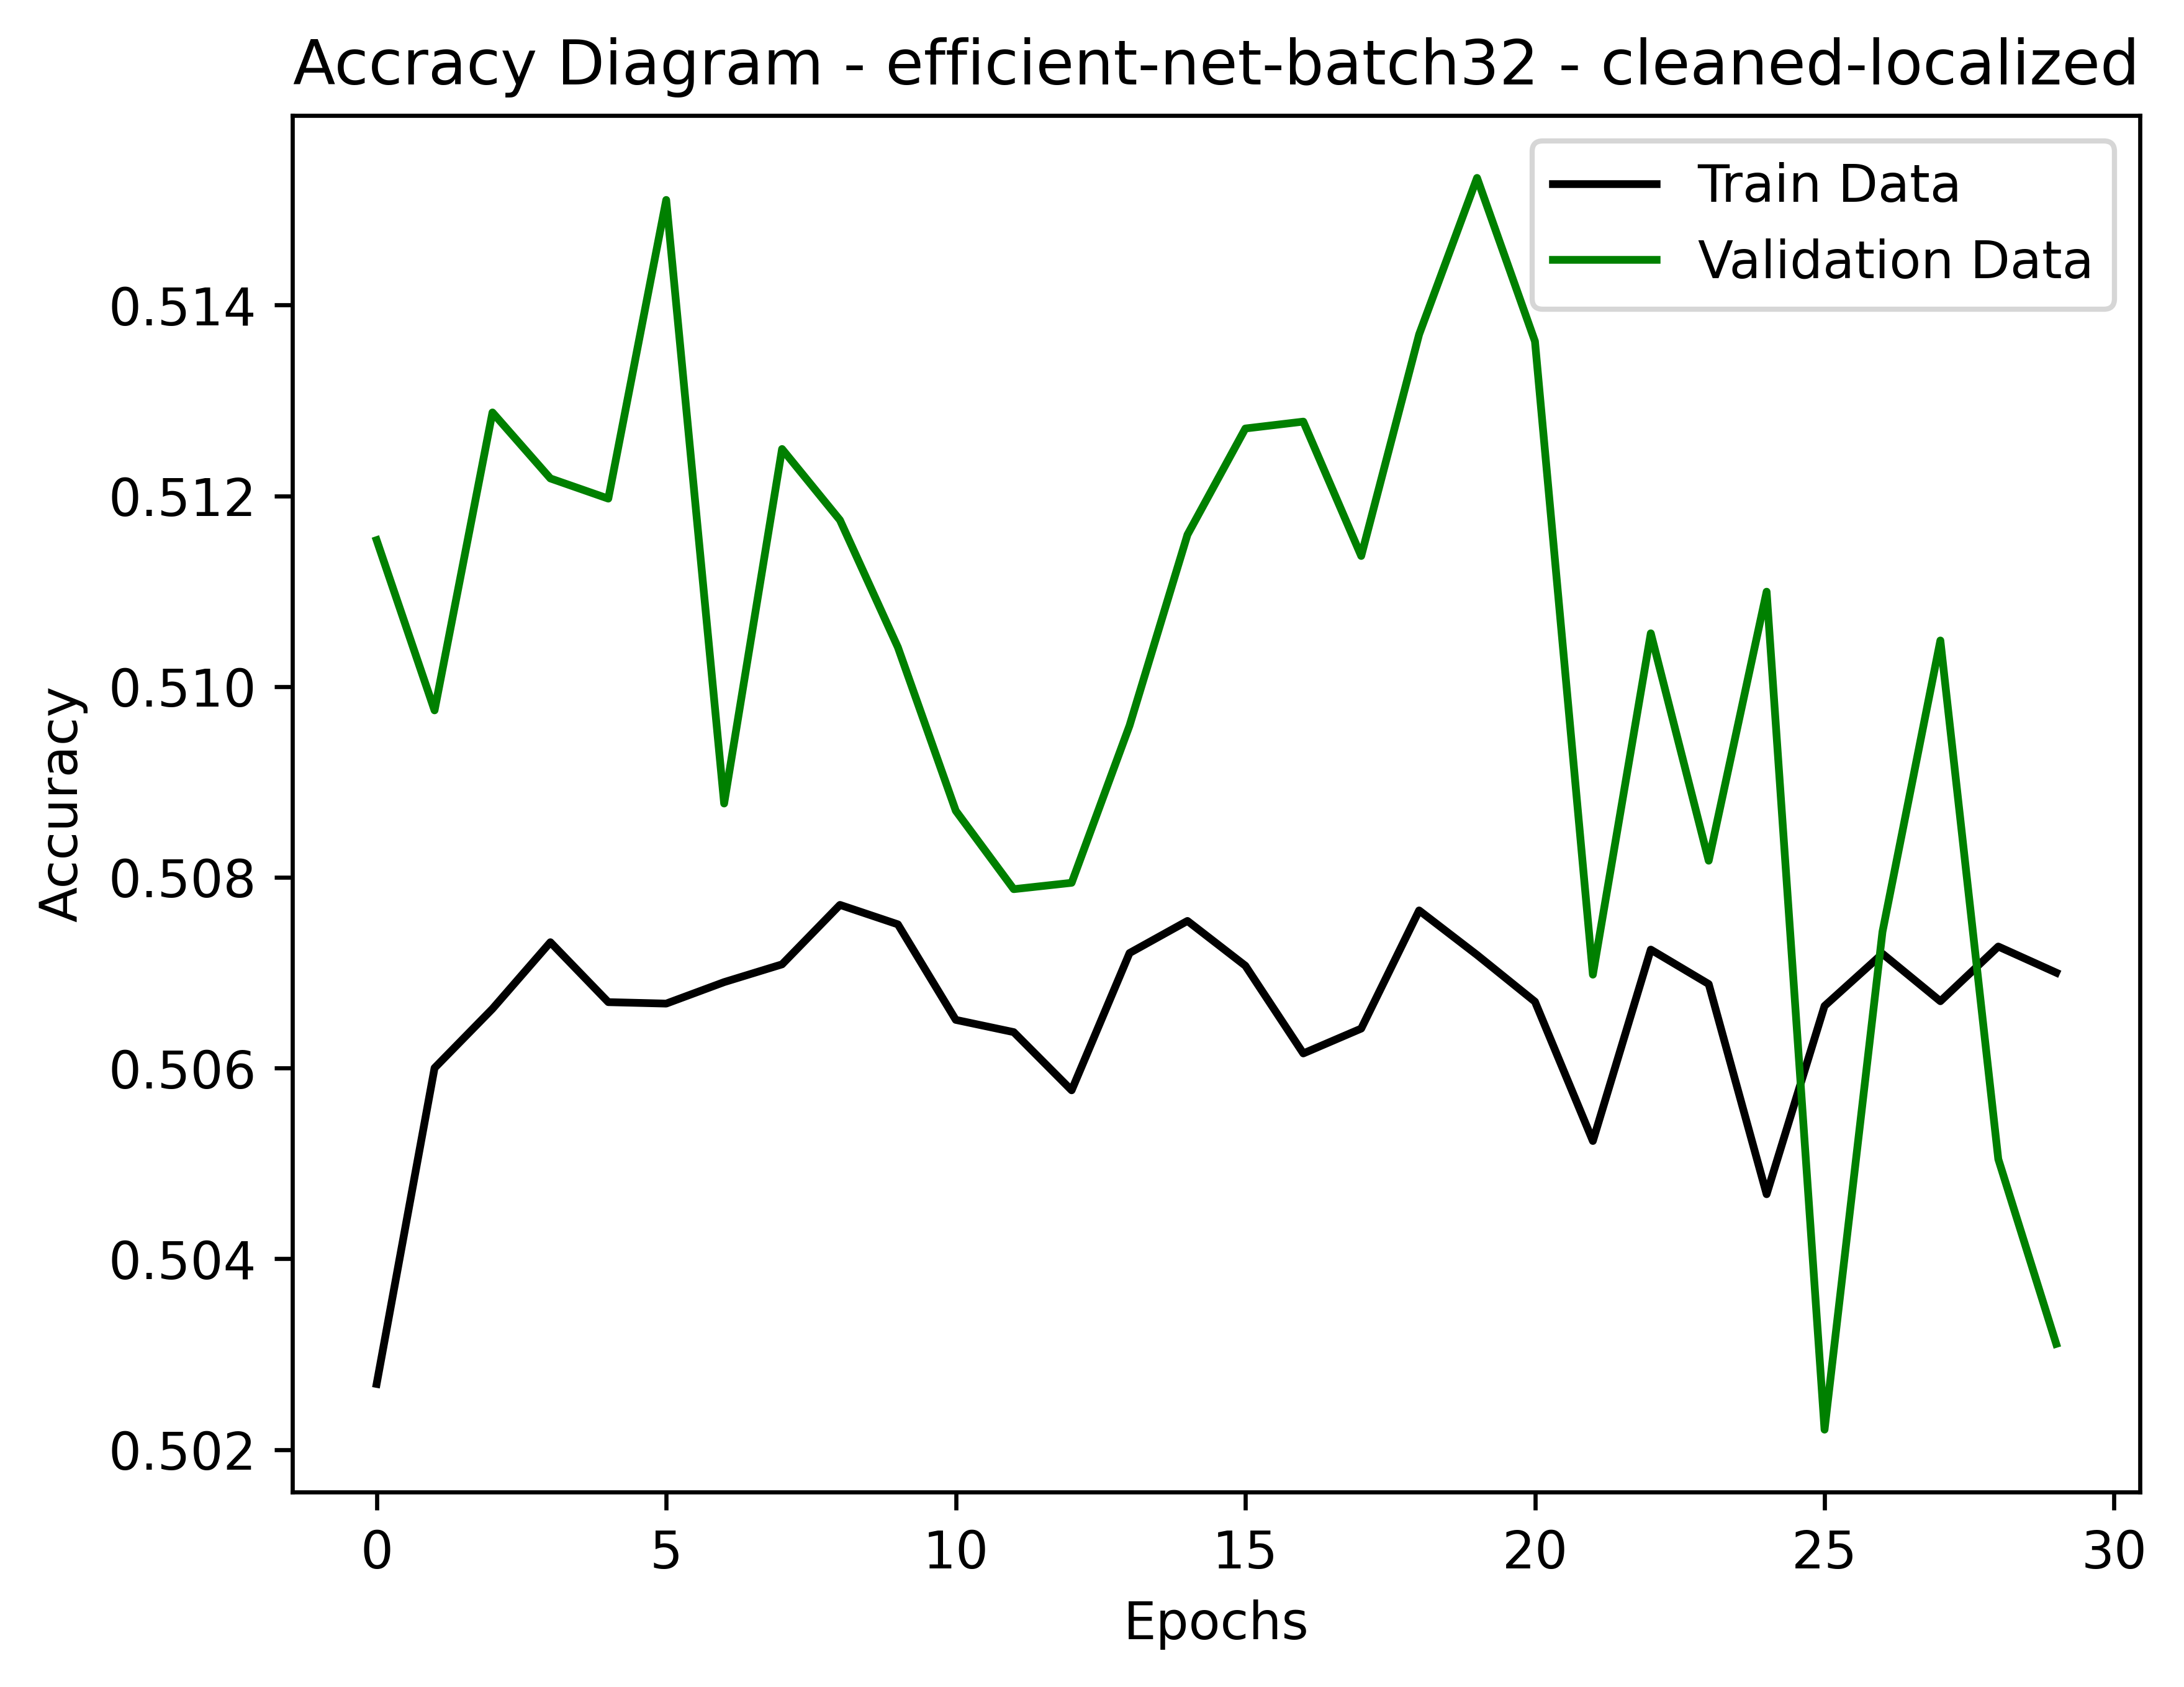

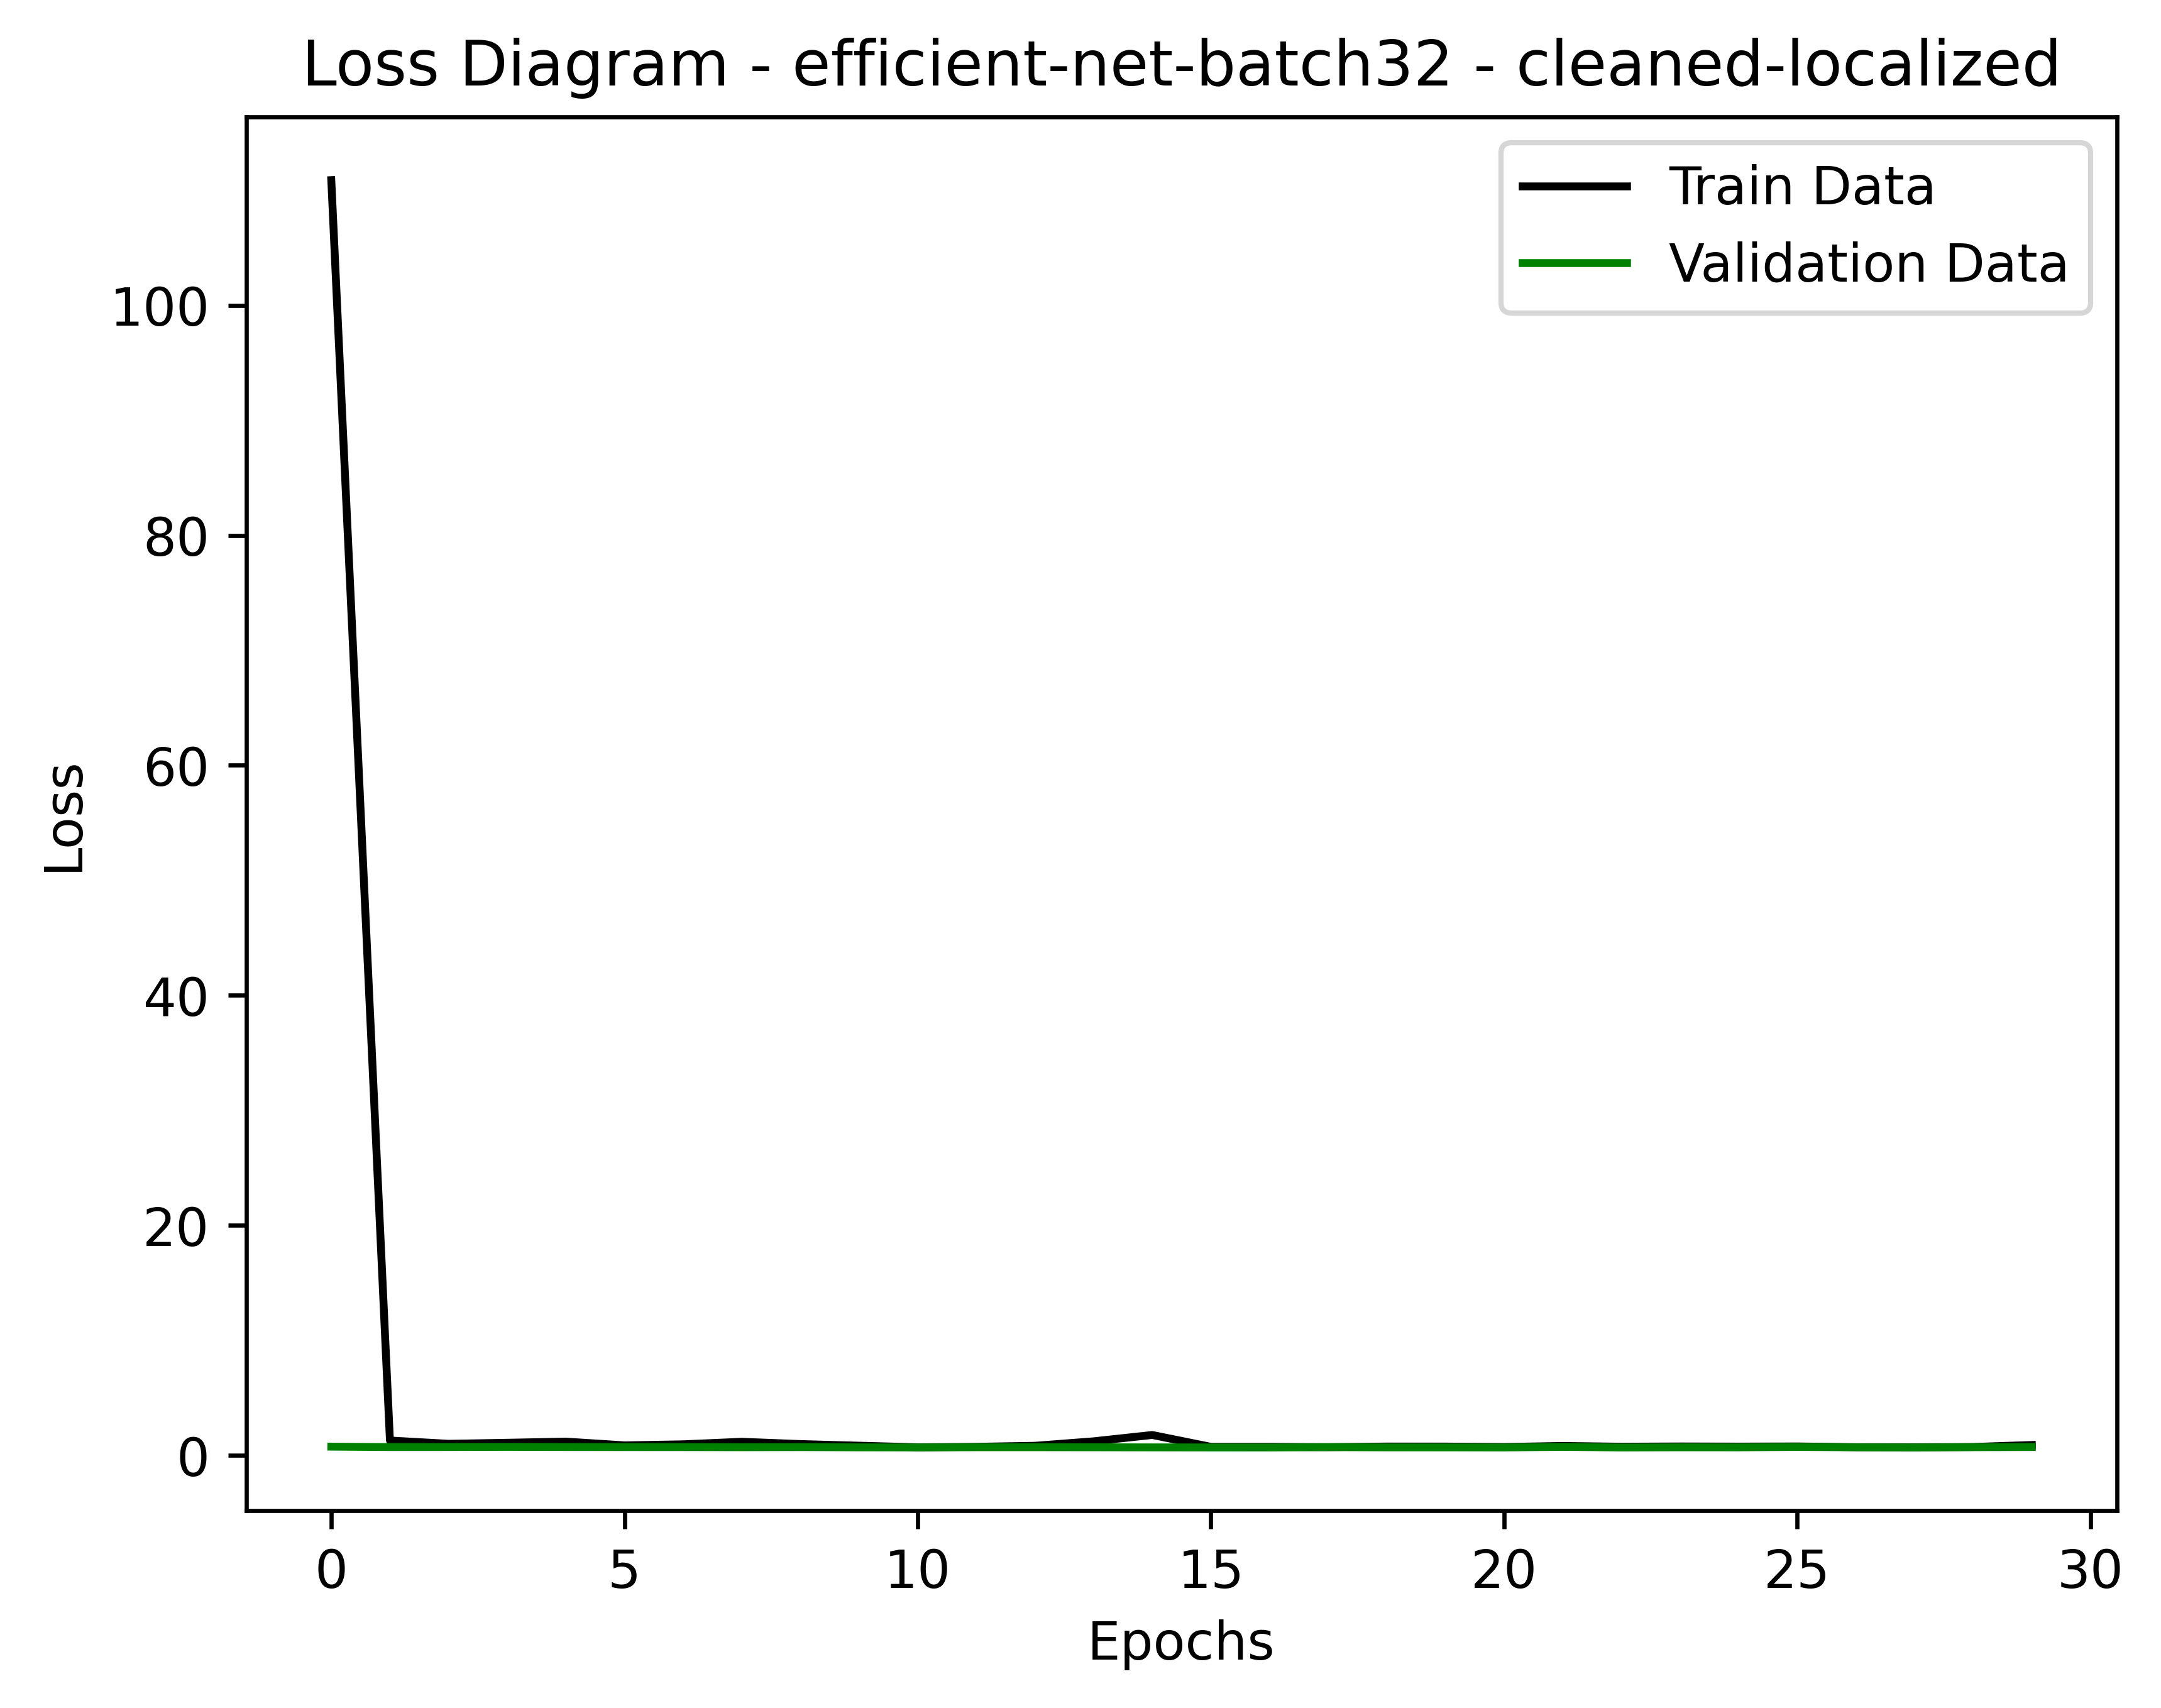

In [13]:
def NetPlot(net_histories,n_epch):
    import numpy as np
    import matplotlib.pyplot as plt

    losses=[]
    val_losses=[]
    accuracies=[]
    val_accuracies=[]

    for item in net_histories:

        history=item.history
        loss=history['loss']
        val_loss=history['val_loss']
        accuracy=history['categorical_accuracy']
        val_accuracy=history['val_categorical_accuracy']

        losses.append(loss)
        val_losses.append(val_loss)
        accuracies.append(accuracy)
        val_accuracies.append(val_accuracy)


    losses2=np.zeros((1,n_epch))
    val_losses2=np.zeros((1,n_epch))
    accuracies2=np.zeros((1,n_epch))
    val_accuracies2=np.zeros((1,n_epch))

    for i in losses:
        losses2+=i

    for i in val_losses:
        val_losses2+=i

    for i in accuracies:
        accuracies2+=i

    for i in val_accuracies:
        val_accuracies2+=i
        
    N_SPLITS = 5

    # 10 is number of folds
    losses2=(losses2/N_SPLITS).flatten()
    accuracies2=(accuracies2/N_SPLITS).flatten()
    val_losses2=(val_losses2/N_SPLITS).flatten()
    val_accuracies2=(val_accuracies2/N_SPLITS).flatten()
    
    # print('\nAccuracies: '+ str(accuracies2) +'\nLosses: '+ str(losses2))

    plt.figure('Accracy Diagram',dpi=600)
    plt.title(f'Accracy Diagram - {CNN_MODEL}-batch{BATCH_SIZE} - {DATASET_TYPE}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(accuracies2,color='black')
    plt.plot(val_accuracies2,color='green')
    plt.legend(['Train Data','Validation Data'])
    plt.savefig(f'{RESULTS_PATH}/Accuracy-Diagram-{CNN_MODEL}-batch{BATCH_SIZE}.jpg')

    plt.figure('Loss Diagram',dpi=600)
    plt.title(f'Loss Diagram - {CNN_MODEL}-batch{BATCH_SIZE} - {DATASET_TYPE}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(losses2,color='black')
    plt.plot(val_losses2,color='green')
    plt.legend(['Train Data','Validation Data'])
    plt.savefig(f'{RESULTS_PATH}/Loss-Diagram-{CNN_MODEL}-batch{BATCH_SIZE}.jpg')
    
NetPlot(lst_history,N_EPOCHS)

In [14]:
# Zipando pasta com resultados
import zipfile

def compactar_pasta(pasta, nome_arquivo_zip):
    with zipfile.ZipFile(nome_arquivo_zip, 'w', zipfile.ZIP_DEFLATED) as zip_file:
        for root, _, files in os.walk(pasta):
            for arquivo in files:
                caminho_completo = os.path.join(root, arquivo)
                zip_file.write(caminho_completo, os.path.relpath(caminho_completo, pasta))

nome_arquivo_zip = f'{VERSION}-results.zip'
compactar_pasta(RESULTS_PATH, nome_arquivo_zip)